In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from qiskit import *
import numpy as np
import random
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Gate

%matplotlib inline
import matplotlib.pyplot as plt

#IBMQ.load_account()

In [2]:
#
# StackOverflow 
# https://stackoverflow.com/questions/10321978/integer-to-bitfield-as-a-list
#
#  but reversed so the index is the bit position
#  and padded with the right number of leading zeros
#


def revbitfield(n, numbits):
    ans = [ 0 ] * numbits
    bits = [int(digit) for digit in bin(n)[2:]]# [2:] to chop off the "0b" part
    p = len(ans)-len(bits)
    for i in range(len(bits)):
        ans[i+p] = bits[i]
    return ans[::-1] # reverse

In [3]:
ss = "01111101"
spacing = False
def rotate(qc, qr, theta):
    qc.u3(theta*2, 0, 0, qr)
    return qc

def identity(qc, qr):
    qc.iden(qr)
    return qc

def spacer(qc, qr, spacing=spacing):
    if spacing:
        qc.iden(qr)

def applyInput(q, val):
    qc = q.qc
    qx = q.qx
    n = len(q.qx)
    bits = revbitfield(val, n)
    for i in range(n):
        if bits[i]==0:
            qc.iden(qx[i])
        else:
            qc.x(qx[i])
    return q

In [4]:
##
##  Provide functionality for all quantum circuits
##
class QC:
    def __init__(self):
        self.qc = QuantumCircuit()

    def em(self, shots=512):
        em = BasicAer.get_backend("qasm_simulator")
        job = execute(self.qc, em, shots=shots)
        hist = job.result().get_counts()
        return hist
    
    def sv(self):
        svs = BasicAer.get_backend("statevector_simulator")
        job = execute(self.qc, svs)
        ket = job.result().get_statevector()
        return ket
   
    def draw(self, output='text'):
        return self.qc.draw(output=output)
    
    def barrier(self):
        self.qc.barrier()

In [5]:
##
## BV circuit with n bits for x
##
class BV(QC):
    def __init__(self, n):
        super().__init__()
        self.n = n
        self.qx = QuantumRegister(n, 'x')
        self.qc.add_register(self.qx)
        self.qb = QuantumRegister(1, 'b')
        self.qc.add_register(self.qb)
    
    def begin(self):
        n = self.n
        for i in range(n):
            self.qc.h(self.qx[i])
        self.qc.x(self.qb[0])
        self.qc.h(self.qb[0])
        return self
        
    def Uf(self):
        return self
    
    def end(self):
        n = self.n
        qx = self.qx
        qc = self.qc
        qb = self.qb
        for i in range(n):
            qc.h(qx[i])
        return self
            
    def measure(self):
        n = self.n
        qx = self.qx
        qc = self.qc
        qb = self.qb
        crb = ClassicalRegister(1, 'crb')
        qc.add_register(crb)
        qc.measure(qb[0],crb[0])
        crx = ClassicalRegister(n, 'crx')
        qc.add_register(crx)
        for i in range(n):
            qc.measure(qx[i],crx[i])
        return self
        
    def make(self):
        self.begin()
        self.barrier()
        self.Uf()  # almost certainly overridden by extending class
        self.qc.x(self.qb[0])   # only for the last question
        self.barrier()
        self.end()
        self.barrier()
        self.measure()
        return self

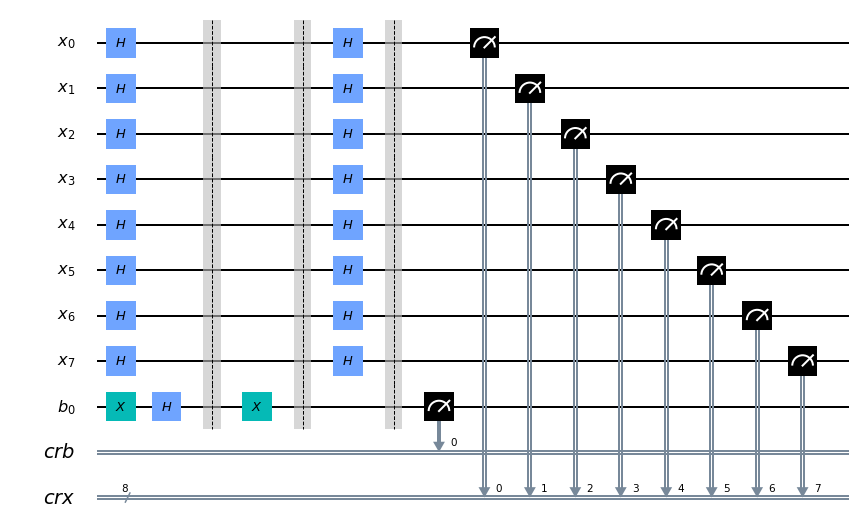

In [6]:
BV(8).make().draw(output='mpl')

In [7]:
class BVExample(BV):
    def __init__(self):
        super().__init__(8)

    def Uf(self):
        for i in range(8):
            if(ss[i] == "1"):
                print(i)
                self.qc.cx(self.qx[i],self.qb[0])
        return self

In [8]:
def gen():
    #ss = "0110"
    return BVExample()

In [9]:
s = gen().make()

1
2
3
4
5
7


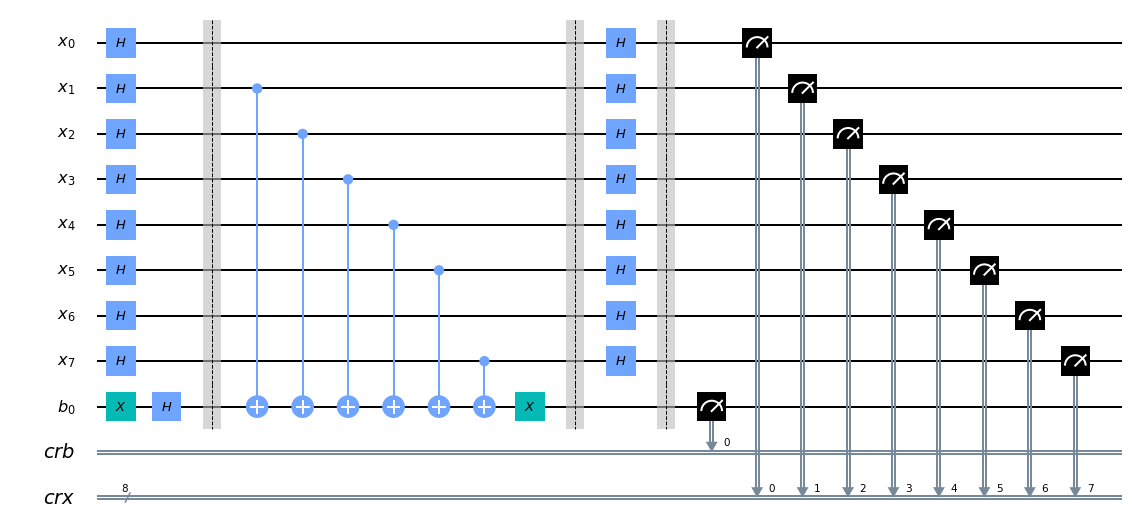

In [10]:
s.draw(output='mpl')

In [11]:
job = execute(s.qc, BasicAer.get_backend('qasm_simulator'), shots=512)

In [12]:
res = job.result()
print(res)

Result(backend_name='qasm_simulator', backend_version='2.0.0', header=Obj(backend_name='qasm_simulator', backend_version='2.0.0'), job_id='7229072b-0041-4586-ab5f-d4baf392f3e7', qobj_id='8daa96ac-7d31-45ca-8fdd-0e59b4f5ae43', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x17c=243, 0x17d=269)), header=Obj(clbit_labels=[['crb', 0], ['crx', 0], ['crx', 1], ['crx', 2], ['crx', 3], ['crx', 4], ['crx', 5], ['crx', 6], ['crx', 7]], creg_sizes=[['crb', 1], ['crx', 8]], memory_slots=9, n_qubits=9, name='circuit1', qreg_sizes=[['x', 8], ['b', 1]], qubit_labels=[['x', 0], ['x', 1], ['x', 2], ['x', 3], ['x', 4], ['x', 5], ['x', 6], ['x', 7], ['b', 0]]), meas_level=<MeasLevel.CLASSIFIED: 2>, name='circuit1', seed_simulator=1985272115, shots=512, status='DONE', success=True, time_taken=0.01928400993347168)], status='COMPLETED', success=True, time_taken=0.019330978393554688)


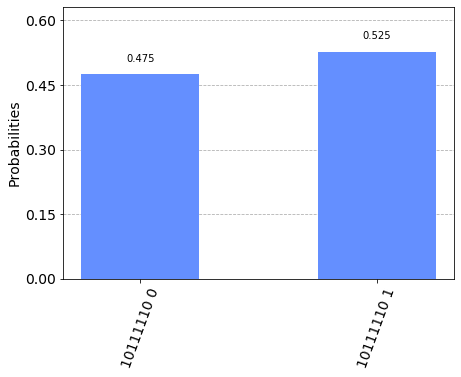

In [13]:
counts = res.get_counts()
plot_histogram(counts)

In [128]:
# provider = IBMQ.get_provider(hub='ibm-q')
# provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [129]:
# for backend in provider.backends():
#     print( backend.status() )

BackendStatus(backend_name='ibmq_qasm_simulator', backend_version='0.1.547', operational=True, pending_jobs=2, status_msg='active')
BackendStatus(backend_name='ibmqx2', backend_version='2.0.5', operational=True, pending_jobs=1, status_msg='active')
BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.1.0', operational=True, pending_jobs=5, status_msg='active')
BackendStatus(backend_name='ibmq_vigo', backend_version='1.0.2', operational=True, pending_jobs=8, status_msg='active')
BackendStatus(backend_name='ibmq_ourense', backend_version='1.0.1', operational=True, pending_jobs=14, status_msg='active')
BackendStatus(backend_name='ibmq_london', backend_version='1.1.0', operational=True, pending_jobs=2, status_msg='active')
BackendStatus(backend_name='ibmq_burlington', backend_version='1.1.4', operational=True, pending_jobs=1, status_msg='active')
BackendStatus(backend_name='ibmq_essex', backend_version='1.0.1', operational=True, pending_jobs=4, status_msg='active')
BackendSta

In [130]:
real_device = provider.get_backend('ibmq_burlington')

In [12]:
s = gen().make()
job = execute(s.qc, BasicAer.get_backend('qasm_simulator'), shots=512)

0
1
2


In [13]:
res = job.result()
print(res)

Result(backend_name='qasm_simulator', backend_version='2.0.0', header=Obj(backend_name='qasm_simulator', backend_version='2.0.0'), job_id='d8f9c840-c1e1-4ced-bf49-211023f931de', qobj_id='0a50ed2b-51a1-4760-ae77-6d7e4f4b13c2', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0xe=996, 0xf=1004)), header=Obj(clbit_labels=[['crb', 0], ['crx', 0], ['crx', 1], ['crx', 2], ['crx', 3], ['crx', 4], ['crx', 5], ['crx', 6], ['crx', 7]], creg_sizes=[['crb', 1], ['crx', 8]], memory_slots=9, n_qubits=9, name='circuit3', qreg_sizes=[['x', 8], ['b', 1]], qubit_labels=[['x', 0], ['x', 1], ['x', 2], ['x', 3], ['x', 4], ['x', 5], ['x', 6], ['x', 7], ['b', 0]]), meas_level=<MeasLevel.CLASSIFIED: 2>, name='circuit3', seed_simulator=2069708975, shots=2000, status='DONE', success=True, time_taken=0.040724992752075195)], status='COMPLETED', success=True, time_taken=0.04081106185913086)


In [14]:
counts = res.get_counts()

In [15]:
print(counts)

{'00000111 1': 1004, '00000111 0': 996}


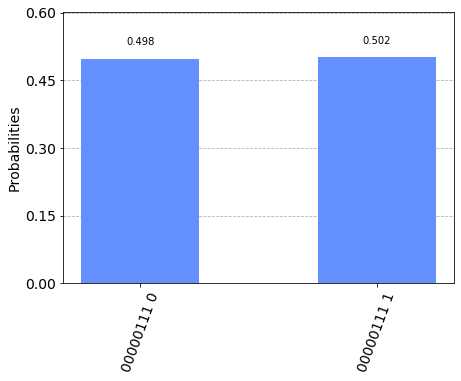

In [16]:
plot_histogram(counts)